# Water Pumps: EDA
**Plan:**
1. Relationships between date recorded and geographical location.
2. Relations between groups of categorical data.
3. Distributions of numerical data.

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

## Load Cleaned Data

In [2]:
df = pd.read_csv('../data/clean/cleaned_data.csv', index_col='id')

In [3]:
df.head()

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
0,non functional,0.0,2012-11-13,Tasaf,0,TASAF,33.125828,-5.118154,Mratibu,0,...,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
1,functional,0.0,2011-03-05,Shipo,1978,SHIPO,34.770717,-9.395642,none,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
2,functional,0.0,2011-03-27,Lvia,0,LVIA,36.115056,-6.279268,Bombani,0,...,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
3,functional,10.0,2013-06-03,Germany Republi,1639,CES,37.147432,-3.187555,Area 7 Namba 5,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
4,non functional,0.0,2011-03-22,Cmsr,0,CMSR,36.164893,-6.099289,Ezeleda,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 74247
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59400 non-null  object 
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 59400 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              59400 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59400 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

## EDA
### Data types
Inspect the dataset above reveals that the categorical variable data types were lost when converting the file to a csv file. I will re-add them here.

In [17]:
categorical_vars = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code',
                   'lga', 'ward', 'public_meeting', 'permit', 'construction_year',
                   'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group',
                   'payment_type', 'water_quality', 'quality_group', 'quantity_group', 'source', 'source_type', 
                    'source_class', 'waterpoint_type', 'waterpoint_type_group', 'scheme_management', 'status_group', 
                   'payment', 'quantity']

In [18]:
categorical_dict = {x: 'category' for x in categorical_vars}

In [20]:
df = df.astype(categorical_dict)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 74247
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   status_group           59400 non-null  category
 1   amount_tsh             59400 non-null  float64 
 2   date_recorded          59400 non-null  object  
 3   funder                 59400 non-null  category
 4   gps_height             59400 non-null  int64   
 5   installer              59400 non-null  category
 6   longitude              59400 non-null  float64 
 7   latitude               59400 non-null  float64 
 8   wpt_name               59400 non-null  category
 9   num_private            59400 non-null  int64   
 10  basin                  59400 non-null  category
 11  subvillage             59400 non-null  category
 12  region                 59400 non-null  category
 13  region_code            59400 non-null  category
 14  district_code          59400 non-null 

### Dates and Geographical location
As indicated during data wrangling, it appears that the geographical locations were recorded twice. I will investigate on whether there is a relationship between when the record was made and the location.

In [22]:
df_value_counts = df[['longitude', 'latitude']].value_counts().reset_index().rename(columns={0:'value_count'})

In [23]:
df_value_counts['value_count'].value_counts()

1       57450
2          69
1812        1
Name: value_count, dtype: int64

**Observations:**
* The majority of the geographical locations are unique.
* 69 geographical locations are recorded twice.
    * Could these pumps have been recorded on different days?
* One geographical location was recorded 1812 times.
    * This seems suspicious and is worth investigating.

In [24]:
df_value_counts[df_value_counts['value_count'] == 1812]

,longitude,latitude,value_count
0,0.0,-2.000000e-08,1812


**Question:** Do these geographical coordinates even fall within the borders of Tanzania?

A Google map inspection reveals that these coordinates fall within the Atlantic Ocean! Therefore, they must have been used to indicate pumps with missing geographical information.

In [25]:
1812 / len(df)

0.030505050505050504

Three percent of the pumps are missing geographical locations. This is small, but not insignificant.

In [26]:
doubled_locations = []
grouped_locations = df.groupby('longitude')
for longitude, group in grouped_locations:
    if len(group) == 2:
        # doubled_locations.append(group[['date_recorded', 'longitude', 'latitude']])
        doubled_locations.append(group)
df_doubled_locations = pd.concat(doubled_locations)

In [27]:
df_doubled_locations

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
18713,functional,0.0,2011-07-13,He,0,HE,31.619530,-1.793342,Kahindu,0,...,never pay,soft,good,enough,enough,spring,spring,groundwater,improved spring,improved spring
29553,functional,0.0,2011-07-13,He,0,HE,31.619530,-1.793342,Kahindu,0,...,never pay,soft,good,enough,enough,spring,spring,groundwater,improved spring,improved spring
3762,functional,0.0,2011-07-20,P,0,P,32.919861,-2.476680,Kwa Primi Mazula,0,...,per bucket,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
49205,functional,50.0,2011-07-20,P,1187,P,32.919861,-2.476680,Kwa Primi Mazula,0,...,per bucket,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
12320,non functional,0.0,2011-07-20,H,0,H,32.924886,-2.465246,Kwa Kabambo,0,...,never pay,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73876,non functional,0.0,2013-03-15,None,56,None,39.103950,-6.976270,Kwa Mzee Chigongo,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
53921,non functional,0.0,2013-03-15,None,56,None,39.105307,-6.975594,Kwa Nyerere,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
56342,non functional,0.0,2013-03-15,None,56,None,39.105307,-6.975594,Kwa Nyerere,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other


In [28]:
duplicate_rows = df_doubled_locations.duplicated(keep='first')

In [29]:
duplicate_rows.sum()

1

**Observations:**
There are 146 duplicated locations. Of these, only one row in the `DataFrame` is exactly duplicated.

I will inspect a few pairs of rows with duplicated locations and see if there are any columns with different values.

In [30]:
df_doubled_locations.iloc[4:6, :].T

id,12320,21107
status_group,non functional,non functional
amount_tsh,0,0
date_recorded,2011-07-20,2011-07-20
funder,H,H
gps_height,0,1171
installer,H,H
longitude,32.9249,32.9249
latitude,-2.46525,-2.46525
wpt_name,Kwa Kabambo,Kwa Kabambo
num_private,0,0


There are a few columns that show missing values between the pairs of rows. These columns include: `construction_year`, `population`, `gps_height`.

## Distributions of numerical variables

In [31]:
df_numerical = df.select_dtypes(include=['float64', 'int64'])

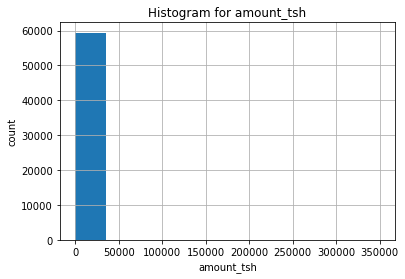

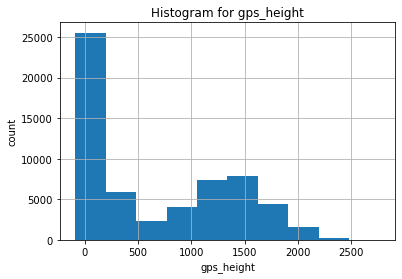

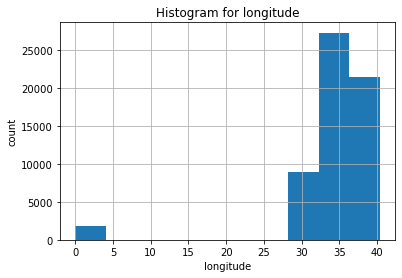

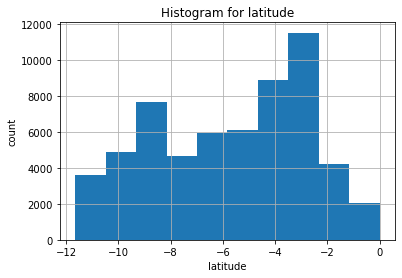

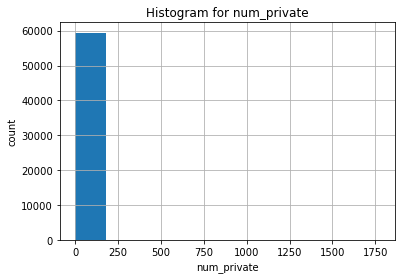

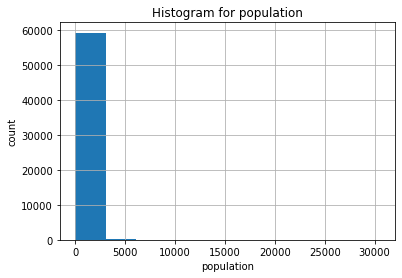

In [32]:
for column in df_numerical.columns:
    df_numerical[column].hist()
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('count')
    plt.show()

In [35]:
df_numerical.describe().T

,count,mean,std,min,25%,50%,75%,max
amount_tsh,59400.0,317.650385,2997.574558,0.00000,0.000000,0.000000,20.000000,3.500000e+05
gps_height,59400.0,668.297239,693.116350,-90.00000,0.000000,369.000000,1319.250000,2.770000e+03
longitude,59400.0,34.077427,6.567432,0.00000,33.090347,34.908743,37.178387,4.034519e+01
latitude,59400.0,-5.706033,2.946019,-11.64944,-8.540621,-5.021597,-3.326156,-2.000000e-08
num_private,59400.0,0.474141,12.236230,0.00000,0.000000,0.000000,0.000000,1.776000e+03
population,59400.0,179.909983,471.482176,0.00000,0.000000,25.000000,215.000000,3.050000e+04


0.2 350000.0


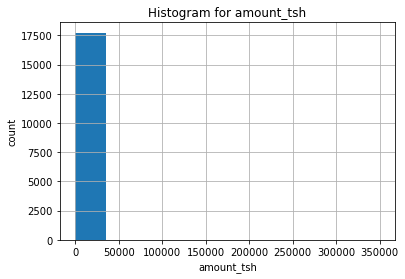

-90 2770


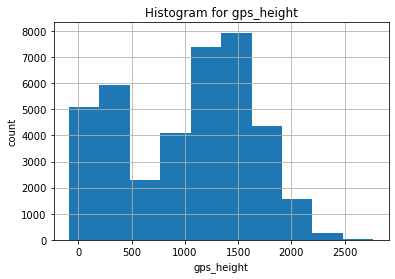

29.6071219 40.34519307


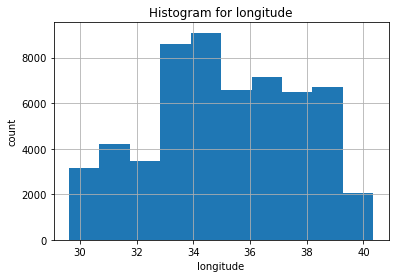

-11.64944018 -2e-08


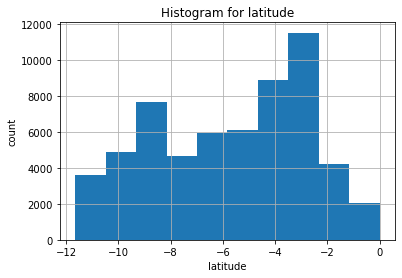

1 1776


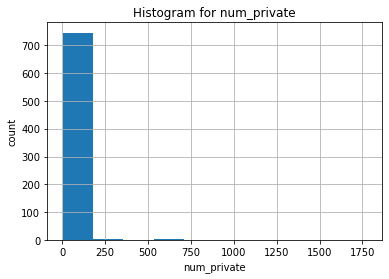

1 30500


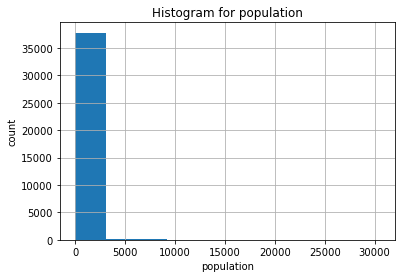

In [40]:
for column in df_numerical.columns:
    non_zero = df_numerical[column] != 0.0
    df_numerical.loc[non_zero, column].hist()
    print(df_numerical.loc[non_zero, column].min(), df_numerical.loc[non_zero, column].max())
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('count')
    plt.show()

0.2 350000.0


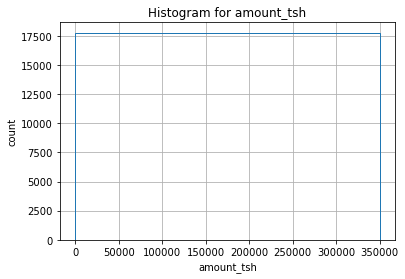

-90 2770


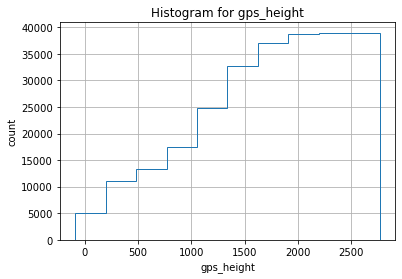

29.6071219 40.34519307


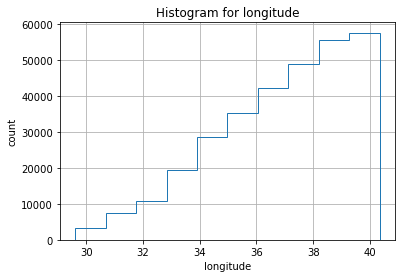

-11.64944018 -2e-08


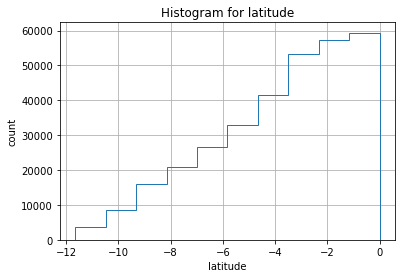

1 1776


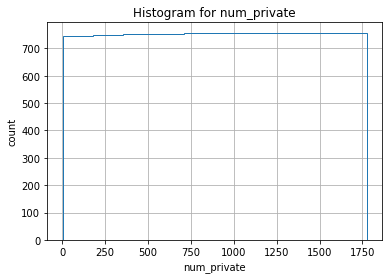

1 30500


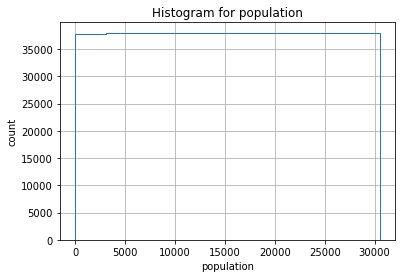

In [45]:
for column in df_numerical.columns:
    non_zero = df_numerical[column] != 0.0
    df_numerical.loc[non_zero, column].hist(cumulative=True, histtype='step')
    print(df_numerical.loc[non_zero, column].min(), df_numerical.loc[non_zero, column].max())
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('count')
    plt.show()

Some of these distributions seem very skewed, with mostly small values and a few very large values. I will investigate this further using box plots.

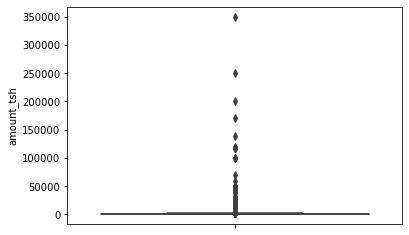

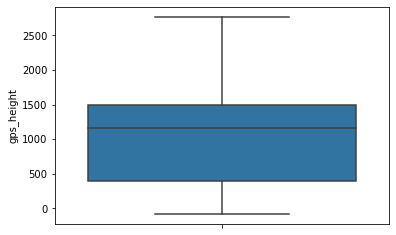

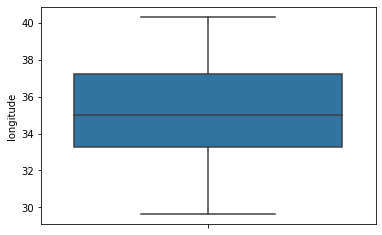

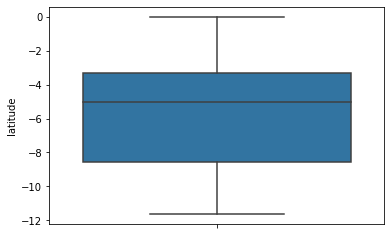

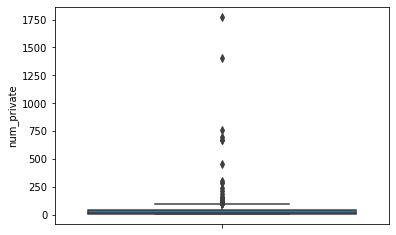

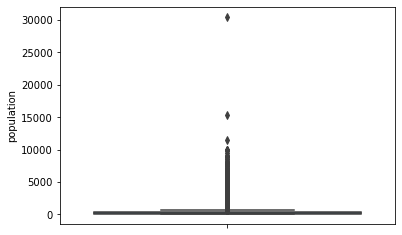

In [47]:
for column in df_numerical.columns:
    non_zero = df_numerical[column] != 0.0
    subset = df_numerical.loc[non_zero, column]
    sns.boxplot(y=subset)
    plt.show()